In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub
import os                                                ##  Modul os je součástí standardní knihovny Pythonu a umožňuje pracovat se soubory a adresáři v operačním systému. 
                                                         ##  Často se používá ke čtení/zápisu souborů, získání cest k souborům a manipulaci s adresáři. 

from PIL import Image                                    ## PIL (Python Imaging Library, dnes známá jako Pillow) je knihovna pro manipulaci s obrázky. 
                                                         ## Image umožňuje otevírat, upravovat a ukládat obrázky ve formátech jako PNG, JPEG, BMP atd. 

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split     ## Rozdělení datasetu na trénovací a testovací část
from keras.utils import to_categorical                   ##  Konverze štítků do One-Hot Encoding, Místo číselného označení jako 0, 1, 2, 
                                                         ##  což by mohlo způsobit chyby v učení (síť by mohla mylně považovat 2 za „větší“ než 1), použijeme One-Hot Encoding:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout
)
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionV3
from keras.applications import MobileNetV3Large     ## je předtrénovaný model hlubokého učení určený pro rozpoznávání obrazu.
                                                    ## Model je předtrénován na obrovském datasetu ImageNet a lze jej dále upravit (tzv. transfer learning).
from keras.layers import GlobalAveragePooling2D     ## redukuje dimenzionalitu výstupních dat.
from keras.models import Model                      ## Model umožňuje sestavit vlastní architekturu neuronové sítě v Kerasu.
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.regularizers import l2
from keras.utils import to_categorical

In [4]:
def plot_history(history):
  """
  Funkce na vykreslení dat z objectu history -> vrací ho metoda fit keras modelu
  """
  # plot the Loss curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)

  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  # plot the Accuracy curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
  plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)
  plt.show()

## Načtení a preprocessing dat

In [149]:
path = r"C:\Users\zitao\Documents\PETR\DATA_SCIENCE\EMOCE"

In [150]:
# data se stáhly sem -> ručně jsem hledal, od jaké úrovně složek už jsou data
fotky_emoce = os.listdir(f"{path}/test")
fotky_emoce

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [154]:
# potřebuji načíst fotky, k fotkám labely a uložit si, jaký label patří k jaké emoci
X_test = []     ## Sem budeme ukládat načtené obrázky jako numpy array
y_test = []     ## Sem budeme ukládat číselné labely (indexy emocí)
encoding = {}    ##  Mapa, která přiřazuje čísla (indexy) konkrétním emocím
# pro každou složku s figurkami
for index, emoce in enumerate(fotky_emoce):        # fotky_emoce -  seznam složek, kde každá složka obsahuje fotky jedné emoce (např. "happy", "sad", "angry"), 
                                                   # enumerate(fotky_emoce) nám umožní přiřadit každé emoci unikátní číslo (index).
  # uložíme si přiřazení číel k labelům y
  encoding[index] = emoce
  # složka s fotkami kontrétních emoci
  folder_path = os.path.join(f"{path}/test", emoce)

  # sem načteme fotky konkrétních emoci
  image_list = []      #  Vytvoříme prázdný list, kam budeme ukládat obrázky pro aktuální emoci.
  # pro každý soubor ze složky
  for filename in os.listdir(folder_path):
    # pokud se jedná o .jpg
    if filename.endswith(".jpg"):      # Projdeme všechny soubory ve složce aktuální emoce.
        # cesta ke kokrétnímu souboru
        img_path = os.path.join(folder_path, filename)
        # načti obrázek ze souboru
        img = Image.open(img_path)
        # Změň rozlišení na 224x224 -> všechny budou mít stejný rozměr
        img_resized = img.resize((48, 48))         #  # Změníme velikost na 48x48 pixelů, Změníme velikost obrázku, aby všechny měly stejný rozměr, To je důležité pro konzistentní vstupy do neuronové sítě.
        # převeď na numpy array
        img_array = np.array(img_resized)
        # přidat do listu k ostatním
        image_list.append(img_array)
  # do X přidej obrázky z další složky (respektive emoce)
  X_test += image_list    #   Přidáme všechny obrázky z této složky do seznamu X.
  # vytvoříme list s labely (rovnou jako čísla, ať nemusíme pozdějí dělat encoding)
  # přiřazení čísel k labelům máme v proměnné 'encoding'
  y_test += [index] * len(image_list)

In [152]:
# převést list s numpy arrayi pro každou emoci na numpy array (tenzor)
X_test = np.stack(X_test)
# převést list y na numpy array
y_test = np.array(y_test)

In [153]:
y_test

array([0, 0, 0, ..., 6, 6, 6])

In [121]:
# transfer learning viz. níže -> zvolili jsme Mobilnetv3 jako základ
# ten vyžaduje hodnoty pixelů v rozmezí od 0-255 -> neškálovat!
## X_not_scaled = X.copy()

In [122]:
# škálujeme pro náš vlastní model,  Normalizování obrázků
## X = X / 255

In [123]:
# # rozdělení, trénink test
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42)
# # one hot encoding y -> musí sedět rozměr s výstupem softmax vrstvy
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [124]:
# early = EarlyStopping(
#     # sleduj přesnost u validačních dat
#     monitor="val_accuracy",
#     # pokud se nezlepší alespoň o 0.3%
#     min_delta=0.003,
#     # za posledních 10 epoch
#     patience=10,
#     # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
#     restore_best_weights=True,
#     ## start_from_epoch = 50
# )

# save = ModelCheckpoint(
#     # kam uložit model
#     filepath="best_model.keras",
#     # sleduj přesnost u validačních dat
#     monitor="val_accuracy",
#     # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
#     save_best_only=True,
#     # ulož do jednoho souboru architekturu i váhy
#     save_weights_only=False,
#     # po každé epoše
#     save_freq="epoch"
# )

## Vlastní neuronka

In [125]:
# # vytvoříme vlastní model - inspirace VGG16 architektura
# model = Sequential()
# # vstup musí sedět na X
# model.add(Input(shape=(48, 48, 1)))
# ## model.add(Input(shape=X_train.shape[1:]))
# # blok konvoluce s poolingem
# model.add(Conv2D(32, (3, 3),input_shape=(48, 48, 1)))
# model.add(MaxPooling2D())
# ## model.add(Dropout(0.2))  ## pridano
# model.add(Conv2D(32, (3, 3)))
# model.add(MaxPooling2D())
# ## model.add(Dropout(0.3))   ## pridano
# model.add(Conv2D(64, (3, 3)))
# model.add(MaxPooling2D())
# # převést na vektor
# model.add(Flatten())
# # regularizace proti overfittingu
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))   ## kernel_regularizer=l2(0.001)
# # výstupní vrstva -> multiclass single label -> softmax
# model.add(Dense(len(fotky_emoce), activation="softmax"))

# # kompilace
# model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

In [126]:
## Total params:   Celkový počet parametrů ve vašem modelu, které jsou trénovatelné i netrénovatelné dohromady.
## Trainable params:  Počet parametrů, které se mění během trénování – model se učí jejich optimální hodnoty.

In [129]:
model = load_model("best_model.keras")

In [130]:
y_pred = model.predict(X_test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [131]:
y_pred = np.argmax(y_pred, axis=1)

In [132]:
## y_test = np.argmax(y_test, axis=1)

In [133]:
encoding

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

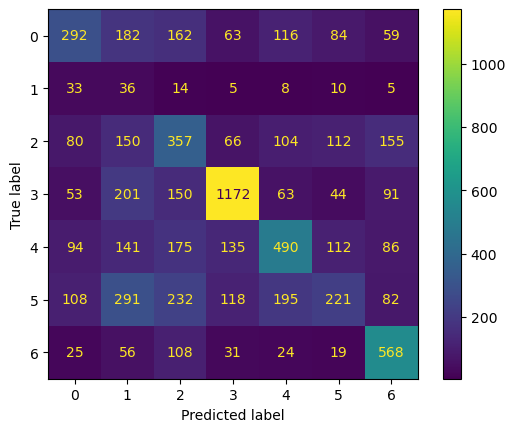

In [134]:
# plt.title("Confusion Matrix  - Vlastní neuronka")  # Název grafu
# plt.xlabel('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')  # Popisek osy X
# plt.ylabel("Skutečné třídy")  # Popisek osy Y

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Transfer learning

## Transfer learning je technika v hlubokém učení, která umožňuje využít znalosti z již natrénovaného modelu pro nový úkol.

In [59]:
# Convert single-channel grayscale to 3-channel format (R=G=B=gray)
rgb_image = np.stack((X_not_scaled,) * 3, axis=-1)

In [60]:
rgb_image.shape

(13441, 48, 48, 3)

In [41]:
# vytvořit trénovací sadu z nenaškálovaných dat
X_train, X_test, y_train, y_test = train_test_split(
    rgb_image, y, test_size=0.2, stratify=y, random_state=42)       ##  20 % dat se použije pro testování, 80 % pro trénování,  42 - zajišťuje, že náhodné rozdělení bude stejné při každém spuštění.
                                                                       ## stratify=y – zajistí, že rozložení tříd (emocí) bude stejné v trénovacím i testovacím datasetu.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [25]:
early_learning = EarlyStopping(
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # pokud se nezlepší alespoň o 0.3%
    min_delta=0.003,
    # za posledních 10 epoch
    patience=10,
    # tak to vypni, a načti váhy z epochy, kdy byla nejvyšší přesnost na validačních datech
    restore_best_weights=True,
    ## start_from_epoch = 50
)

save_learning = ModelCheckpoint(
    # kam uložit model
    filepath="best_model_learning.keras",
    # sleduj přesnost u validačních dat
    monitor="val_accuracy",
    # ulož vždy jen jeden soubor s nejlepší hodnotou metriky
    save_best_only=True,
    # ulož do jednoho souboru architekturu i váhy
    save_weights_only=False,
    # po každé epoše
    save_freq="epoch"
)

In [26]:
# Načtení základního modelu MobileNetV3Large bez vrchní plně propojené vrstvy
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(48, 48, 3),
    name="efficientnetb0",
)

# Zamrznutí základního modelu, aby se jeho váhy během trénování neměnily
base_model.trainable = True

# Vytvoření vlastních vrstev pro specifickou úlohu
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    ## model.add(Dropout(0.5))
    layers.Dense(len(fotky_emoce), activation='softmax')  # 'num_classes' je počet tříd ve vašem datasetu
])

# Kompilace modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 2, 2, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [28]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_learning, save_learning])

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 52s 159ms/step - accuracy: 0.3303 - loss: 1.7389 - val_accuracy: 0.4294 - val_loss: 1.4974
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - accuracy: 0.4304 - loss: 1.5181 - val_accuracy: 0.4120 - val_loss: 1.4992
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - accuracy: 0.4375 - loss: 1.4912 - val_accuracy: 0.4505 - val_loss: 1.4367
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - accuracy: 0.4309 - loss: 1.4814 - val_accuracy: 0.4517 - val_loss: 1.4304
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.4532 - loss: 1.4424 - val_accuracy: 0.4757 - val_loss: 1.4114
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.4537 - loss: 1.4310 - val_accuracy: 0.4769 - val_loss: 1.4051
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 31s 147ms/step - accuracy: 0.4715 - loss: 1.3781 - val_accuracy: 0.4733 - val_loss: 1.4134
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 26s 124ms/step - accuracy: 0.4629 -

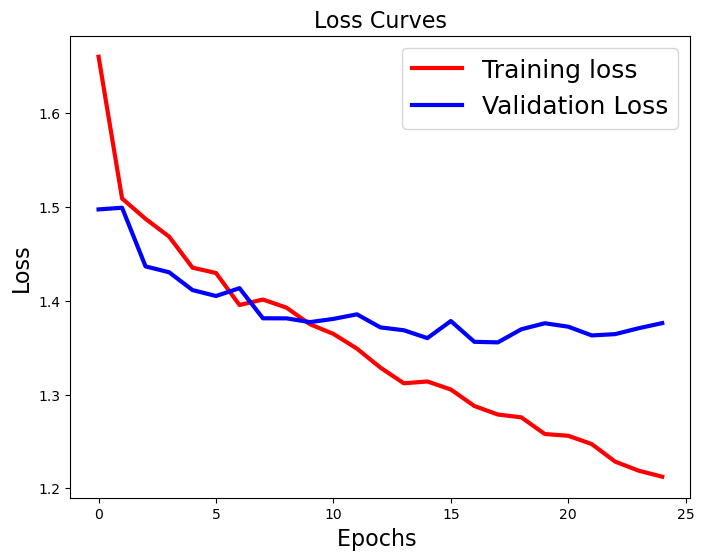

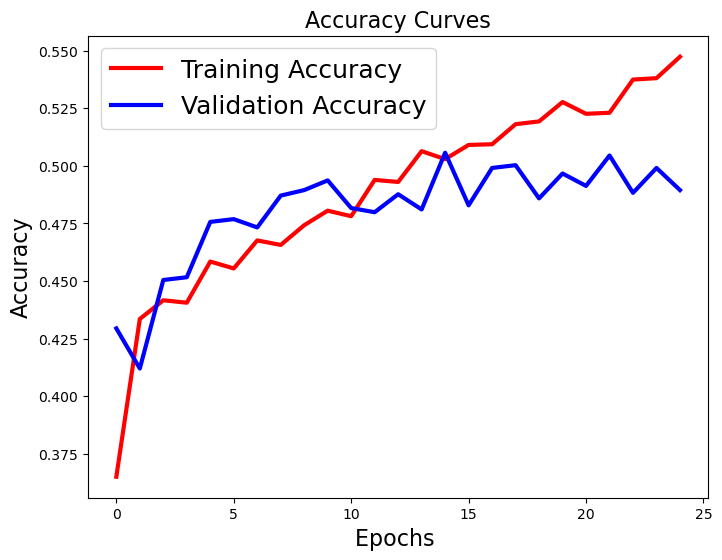

In [29]:
plot_history(history)

In [235]:
X_test_learning = X_test

In [261]:
y_test_learning = y_test

In [252]:
X_test_learning = np.stack(X_test_learning)
# převést list y na numpy array
y_test_learning = np.array(y_test_learning)

In [253]:
X_test_learning = X_test_learning.reshape(-1, 48, 48, 1)

In [254]:
X_test_learning = np.repeat(X_test_learning, 3, axis=-1)

In [255]:
model = load_model("best_model_learning.keras")

In [256]:
y_pred_learning = model.predict(X_test_learning)

673/673 ━━━━━━━━━━━━━━━━━━━━ 99s 142ms/step


In [257]:
X_test_learning.shape

(21534, 48, 48, 3)

In [258]:
## y_pred_learning = np.repeat(y_pred_learning, 3, axis=-1)

In [259]:
y_pred_learning = np.argmax(y_pred_learning, axis=1)

In [260]:
y_test_learning = np.argmax(y_test_learning, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
y_pred_learning = np.argmax(y_pred_learning, axis=1)

In [ ]:
y_test_learning.shape

In [262]:
cm = confusion_matrix(y_test_learning, y_pred_learning)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

ValueError: Found input variables with inconsistent numbers of samples: [7178, 21534]

In [34]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# import os
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# import os
# import numpy as np
# import cv2  # OpenCV pro konverzi na stupně šedi


# # Cesta k adresáři se vstupními obrázky
# input_dir = r"C:\Users\zitao\Documents\PETR\DATA_SCIENCE\EMOCE\test\disgust"  # Změň podle své struktury
# output_dir = r"C:\Users\zitao\Documents\PETR\DATA_SCIENCE\EMOCE\disgust_test"  # Kam se uloží augmentované obrázky

# # Vytvoření adresáře pro augmentované obrázky, pokud neexistuje
# os.makedirs(output_dir, exist_ok=True)

# # Nastavení augmentace
# datagen = ImageDataGenerator(
#     rotation_range=30,        # Náhodná rotace do 30 stupňů
#     width_shift_range=0.2,    # Horizontální posun do 20 % šířky
#     height_shift_range=0.2,   # Vertikální posun do 20 % výšky
#     zoom_range=0.2,           # Náhodný zoom (přiblížení/oddálení)
#     horizontal_flip=True,     # Náhodné otočení
#    ## brightness_range=[0.8, 1.2],  # Jas mezi 80 % a 120 %
#     fill_mode='nearest'       # Vyplnění nových pixelů
# )

# # Procházení obrázků ve složce
# for filename in os.listdir(input_dir):
#     if filename.endswith(".jpg"):  
#         img_path = os.path.join(input_dir, filename)
        
#         # Načtení obrázku a změna velikosti
#         img = load_img(img_path, target_size=(48, 48))
#         x = img_to_array(img)  # Převod na numpy pole
        
#         x = x.astype(np.uint8)
        
#         # Převod na stupně šedi pomocí OpenCV
#         x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)

#         # Reshape na 48x48x1 (1 kanál)
#         x = np.expand_dims(x, axis=-1)

#         # Přidání batch dimenze
#         x = np.expand_dims(x, axis=0)

#         # Generování a ukládání augmentovaných obrázků
#         i = 0
#         for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix="aug", save_format="jpg"):
#             i += 1
#             if i > 10:
#                 break


In [35]:
## img_1 = Image.open(r"C:\Users\zitao\Documents\PETR\DATA_SCIENCE\EMOCE\train_OK\disgust\Training_88580213.jpg")

In [36]:
## img_1 = np.array(img_1)

In [37]:
## plt.imshow(img_1)

In [38]:
img_1.shape

NameError: name 'img_1' is not defined